In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
import Colors
from scipy.interpolate import interp1d
from scipy.stats.stats import pearsonr   

In [2]:
from neupy import algorithms

In [3]:
def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [4]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2',
          'Mesp2','Ripply2','Dppa5a','Gata6','Meox1','Tbx6','T']

In [5]:
g_annotate_h = ['CDX2', 'RSPO3','SOX1','SOX2','WNT3A','FGF8','UNCX','ALDH1A2','MESP2','RIPPLY2','DPPA5','GATA6',
               'MEOX1','TBX6','TBXT']

# Read data

Read data for both mouse and human gastruloids, where I pooled everything together. 
Also, recover the gene correlations

In [6]:
zmdf_mouse = read_csv('../../Lnfg-mGst-tomo/mG_E08F08B10_5dAA.zscore.coutt.tsv', sep = '\t', index_col=0)

In [8]:
zmdf_human = read_csv('../results_postRevJan19/pooledAll_chichiSB45_zscore.tsv', sep = '\t', index_col=0)

let's get the gastruloid data splitted

In [9]:
set([c.rsplit('-')[-1] for c in zmdf_mouse.columns])

{'mG01', 'mG02', 'mG03'}

In [10]:
mg5d = [zmdf_mouse[[c for c in zmdf_mouse.columns if sample in c]] for sample in set([c.rsplit('-')[-1] for c in zmdf_mouse.columns])]


In [11]:
set(['-'.join(c.rsplit('-')[-2:]) for c in zmdf_human.columns])

{'hG01-chi', 'hG02-chi', 'hG03-sb', 'hG04-sb'}

In [12]:
hgchi = [zmdf_human[[c for c in zmdf_human.columns if sample in c]] for sample in ['hG01-chi','hG02-chi']]
hgsb = [zmdf_human[[c for c in zmdf_human.columns if sample in c]] for sample in ['hG03-sb','hG04-sb']]

In [12]:
# genes_mouse_3d = [pd.read_excel('../../mGstl-tomo/results_postRevJan19/geneCorrelations_3dAA.xlsx', sheetname=0)]
# genes_mouse_4d = [pd.read_excel('../../mGstl-tomo/results_postRevJan19/geneCorrelations_4dAA.xlsx', sheetname=i) for i in range(3)]
# genes_mouse_5d = [pd.read_excel('../../mGstl-tomo/results_postRevJan19/geneCorrelations_5dAA.xlsx', sheetname=i) for i in range(10)]

# genes_mouse_3d = read_csv('../../mGstl-tomo/results_postRevJan19/geneCorrelations_3dAA.tsv', sep = '\t', index_col=0)
# genes_mouse_4d = read_csv('../../mGstl-tomo/results_postRevJan19/geneCorrelations_4dAA.tsv', sep = '\t', index_col=0)
# genes_mouse_5d = read_csv('../../mGstl-tomo/results_postRevJan19/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [13]:
genes_mouse_5d = read_csv('../../Lnfg-mGst-tomo/results/lfngMouseGastruloids/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [19]:
genes_human_chi= read_csv('../results_postRevJan19/geneCorrelations_Chi.tsv', sep = '\t', index_col=0)
genes_human_sb= read_csv('../results_postRevJan19/geneCorrelations_ChiSB43.tsv', sep = '\t', index_col=0)

In [21]:
mg5d = [df.loc[genes_mouse_5d.index] for df in mg5d]
# mg4d = [df.loc[genes_mouse_4d.index] for df in mg4d]
# mg3d = [df.loc[genes_mouse_3d.index] for df in mg3d]

hgchi = [df.loc[genes_human_chi.index] for df in hgchi]
hgsb = [df.loc[genes_human_sb.index] for df in hgsb]

# Read orthologs

In [22]:
ortos = read_csv('/Users/anna/Dropbox/gastruloids/data/human-mouse-orthologous.txt.gz', sep = '\t')

In [23]:
del ortos['Transcript stable ID']

In [24]:
ortos = pd.DataFrame(ortos.groupby(list(ortos.columns)).groups.keys(), columns = ortos.columns)

In [25]:
ortos.head()

,Gene stable ID,Mouse gene stable ID,Mouse gene name,Mouse chromosome/scaffold name,Chromosome/scaffold name,Gene name
0,ENSG00000000003,ENSMUSG00000067377,Tspan6,X,X,TSPAN6
1,ENSG00000000005,ENSMUSG00000031250,Tnmd,X,X,TNMD
2,ENSG00000000419,ENSMUSG00000078919,Dpm1,2,20,DPM1
3,ENSG00000000419,ENSMUSG00000093752,Gm20716,2,20,DPM1
4,ENSG00000000457,ENSMUSG00000026584,Scyl3,1,1,SCYL3


In [26]:
def getHumanName(ortos, idx):
    g = ortos.loc[idx,'Gene stable ID']
    g += '_' + ortos.loc[idx,'Gene name'] 
    g += '__' + ortos.loc[idx,'Chromosome/scaffold name']
    return g

def getMouseName(ortos, idx):
    g = ortos.loc[idx,'Mouse gene stable ID']
    g += '_' + ortos.loc[idx,'Mouse gene name'] 
    g += '__' + ortos.loc[idx,'Mouse chromosome/scaffold name']
    return g

In [27]:
def mouse2human_ortos(mgene, ortos = ortos):
    mgs = mgene.rsplit('_')[0]
    mgn = mgene.rsplit('_')[1]
    mgc = mgene.rsplit('_')[-1]
    oidx = ortos[(ortos['Mouse gene stable ID']==mgs)&(ortos['Mouse gene name']==mgn)&(ortos['Mouse chromosome/scaffold name']==mgc)].index
    if len(oidx) == 0:
        hgene = 'None'
    elif len(oidx) == 1:
        hgene = getHumanName(ortos, oidx[0])
    else:
        hgene = '&'.join([getHumanName(ortos, oidx[i]) for i in range(len(oidx))])
    return hgene   

In [28]:
def human2mouse_ortos(hgene, ortos = ortos):
    gs = hgene.rsplit('_')[0]
    gn = hgene.rsplit('_')[1]
    gc = hgene.rsplit('_')[-1]
    oidx = ortos[(ortos['Gene stable ID']==gs)&(ortos['Gene name']==gn)&(ortos['Chromosome/scaffold name']==gc)].index
    if len(oidx) == 0:
        mgene = 'None'
    elif len(oidx) == 1:
        mgene = getMouseName(ortos, oidx[0])
    else:
        mgene = '&'.join([getMouseName(ortos, oidx[i]) for i in range(len(oidx))])
    return mgene

In [29]:
# genes_mouse_3d['human_ortho'] = genes_mouse_3d.apply(lambda x: mouse2human_ortos(x.name, ortos), axis = 1)
# genes_mouse_4d['human_ortho'] = genes_mouse_4d.apply(lambda x: mouse2human_ortos(x.name, ortos), axis = 1)
genes_mouse_5d['human_ortho'] = genes_mouse_5d.apply(lambda x: mouse2human_ortos(x.name, ortos), axis = 1)

In [31]:
genes_human_chi['mouse_ortho'] = genes_human_chi.apply(lambda x: human2mouse_ortos(x.name, ortos), axis = 1)
genes_human_sb['mouse_ortho'] = genes_human_sb.apply(lambda x: human2mouse_ortos(x.name, ortos), axis = 1)

# Comparisons

The upcoming comparisons proceed as follows:

We start with reproducible MOUSE genes. There are the following subcategories:
* Mouse genes with Human ortologs
    - Expressed in the Human system
        - reproducible in the Human system
        - not reproducible in the Human system
    - Not expressed in the Human System
* Mouse genes with no Human ortologs

A similar "tree" stucture applies when we focus on the reproducible HUMAN genes. 

-> Frist let's obtain the list of reproducible genes for each system

In [32]:
pvth = 0.1; nth = 3
pvcols = [c for c in genes_mouse_5d.columns if 'pv_('==c[:4]]
repr_Mgenes_5d = genes_mouse_5d.index[genes_mouse_5d.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [30]:
# pvth = 0.05; nth = 2
# pvcols = [c for c in genes_mouse_4d.columns if 'pv_('==c[:4]]
# repr_Mgenes_4d = genes_mouse_4d.index[genes_mouse_4d.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [31]:
# pvth = 0.01; nth = 1
# pvcols = [c for c in genes_mouse_3d.columns if 'pv_('==c[:4]]
# repr_Mgenes_3d = genes_mouse_3d.index[genes_mouse_3d.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [33]:
pvth = 0.01
repr_Hgenes_Chi = genes_human_chi.index[genes_human_chi['adj-pv'] < pvth]

pvth = 0.01
repr_Hgenes_SB54 = genes_human_sb.index[genes_human_sb['adj-pv'] < pvth]

In [34]:
# len(repr_Mgenes_3d), len(repr_Mgenes_4d)
len(repr_Mgenes_5d)

1461

In [35]:
len(repr_Hgenes_Chi), len(repr_Hgenes_SB54)

(810, 1245)

Required functions

In [36]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [37]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [38]:
reference = 'hchi'
target = 'md5'

In [39]:
! mkdir ../results_postRevJan19/compare_hGst_LfngGst

In [40]:
outname = '../results_postRevJan19/compare_hGst_LfngGst/heatmap_comparison_' + reference + 'VS' + target

In [49]:
if reference == 'md5':
    full_ref_list = genes_mouse_5d
    repr_ref_list = repr_Mgenes_5d
    ref_gst = [df.copy(deep = True) for df in mg5d]
    ortofunc = human2mouse_ortos
elif reference == 'md4':
    full_ref_list = genes_mouse_4d
    repr_ref_list = repr_Mgenes_4d
    ref_gst = [df.copy(deep = True) for df in mg4d]
    ortofunc = human2mouse_ortos
elif reference == 'md3':
    full_ref_list = genes_mouse_3d
    repr_ref_list = repr_Mgenes_3d
    ref_gst = [df.copy(deep = True) for df in mg3d]
    ortofunc = human2mouse_ortos
elif reference == 'hchi':
    full_ref_list = genes_human_chi
    repr_ref_list = repr_Hgenes_Chi
    ref_gst = [df.copy(deep = True) for df in hgchi] 
    ortofunc = mouse2human_ortos
elif reference == 'hsb':
    full_ref_list = genes_human_sb
    repr_ref_list = repr_Hgenes_SB54
    ref_gst = [df.copy(deep = True) for df in hgsb] 
    ortofunc = mouse2human_ortos
    
if target == 'md5':
    colorto = 'mouse_ortho'
    colreforot = 'human_ortho'
    full_target_list = genes_mouse_5d
    repr_target_list = repr_Mgenes_5d
    target_gst = [df.copy(deep = True) for df in mg5d]
elif target == 'md4':
    colorto = 'mouse_ortho'
    colreforot = 'human_ortho'
    full_target_list = genes_mouse_4d
    repr_target_list = repr_Mgenes_4d
    target_gst = [df.copy(deep = True) for df in mg4d]
elif target == 'md3':
    colorto = 'mouse_ortho'
    colreforot = 'human_ortho'
    full_target_list = genes_mouse_3d
    repr_target_list = repr_Mgenes_3d
    target_gst = [df.copy(deep = True) for df in mg3d]
elif target == 'hchi':
    colorto = 'human_ortho'
    colreforot = 'mouse_ortho'
    full_target_list = genes_human_chi
    repr_target_list = repr_Hgenes_Chi
    target_gst = [df.copy(deep = True) for df in hgchi] 
elif target == 'hsb':
    colorto = 'human_ortho'
    colreforot = 'mouse_ortho'
    full_target_list = genes_human_sb
    repr_target_list = repr_Hgenes_SB54
    target_gst = [df.copy(deep = True) for df in hgsb]


In [57]:
ref_gene_list = repr_ref_list

In [43]:
ort_gene_list = []
nonort_gene_list = []
for rg in ref_gene_list:
    tg = full_ref_list.loc[rg,colorto]
    if tg != 'None' and '&' not in tg:
        if tg in full_target_list.index:
            rg2 = full_target_list.loc[tg, colreforot]
            if rg == rg2:
                ort_gene_list.append(rg)
            else:
                nonort_gene_list.append(rg)
        else:
            nonort_gene_list.append(rg)
    else:
        nonort_gene_list.append(rg)

In [44]:
expr_gene_list = []
nonexpr_gene_list = []
partexpr_gene_list = []
for x in ort_gene_list:
    cnt = sum([full_ref_list.loc[x,colorto] in df.index for df in target_gst])
    if cnt == 0:
        nonexpr_gene_list.append(x)
    elif cnt == len(target_gst):
        expr_gene_list.append(x)
    else:
        partexpr_gene_list.append(x)

In [45]:
reprtarget_gene_list = [g for g in expr_gene_list if full_ref_list.loc[g,colorto] in repr_target_list]
nonreprtarget_gene_list = [g for g in expr_gene_list if full_ref_list.loc[g,colorto] not in repr_target_list]

In [46]:
len(ref_gene_list), len(ort_gene_list), len(nonort_gene_list), len(expr_gene_list), len(nonexpr_gene_list), len(partexpr_gene_list), len(reprtarget_gene_list), len(nonreprtarget_gene_list)

(1245, 0, 1245, 0, 0, 0, 0, 0)

In [47]:
for df in target_gst:
    idxs = []
    for gene in df.index:
        if gene in full_target_list.index:
            new_gene = full_target_list.loc[gene, colreforot]
            if '&' in new_gene:
                new_gene = 'None'
        else:
            new_gene = gene
        idxs.append(new_gene)
        
    df.index = idxs

In [48]:
dfs = [df.loc[ref_gene_list] for df in ref_gst] + [df.loc[ref_gene_list] for df in target_gst]
xdf = mergeDfs(dfs)

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


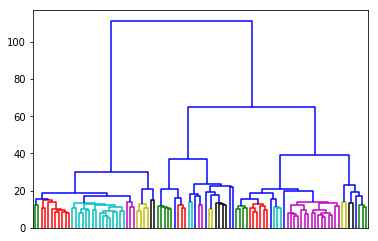

In [500]:
somhcl_xdf_repr = comboCluster(xdf, reprtarget_gene_list, cth=15)

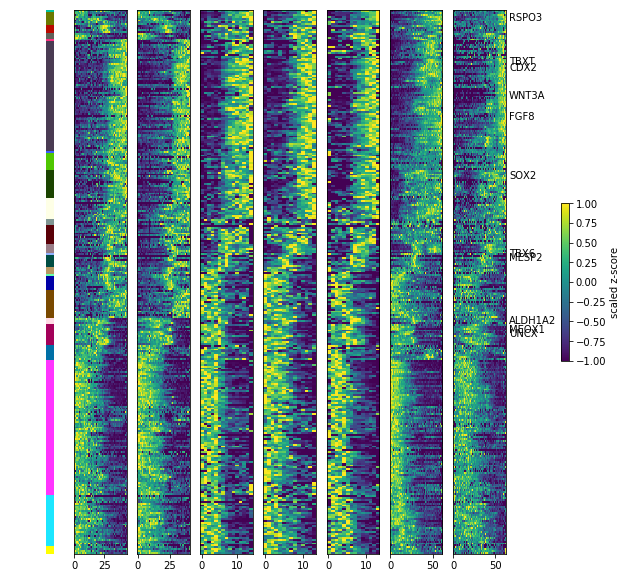

In [501]:
plt.figure(figsize=(10,10))

somhcl = somhcl_xdf_repr
somhcl = somhcl.sort_values(by=['hcl','som'])

gene_order = somhcl.index
Npl = len(dfs)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl['hcl']):
    y = 1.0*len(somhcl[somhcl['hcl'] == i])/len(somhcl)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(dfs):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate_h else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(outname + 'orth_targetExpr_targetRepr.pdf', bbox_inches = 'tight')
somhcl.to_csv(outname + 'orth_targetExpr_targetRepr.tsv', sep = '\t')

plt.show()

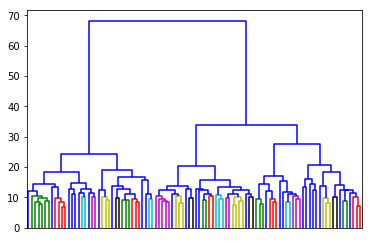

In [502]:
somhcl_xdf_nonrepr = comboCluster(xdf, nonreprtarget_gene_list, cth=11)

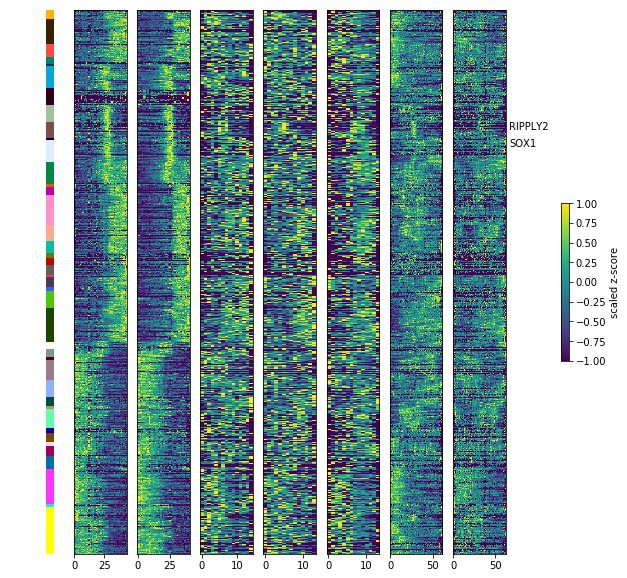

In [503]:
plt.figure(figsize=(10,10))

somhcl = somhcl_xdf_nonrepr

gene_order = somhcl.sort_values(by=['hcl','som']).index
Npl = len(dfs)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl['hcl']):
    y = 1.0*len(somhcl[somhcl['hcl'] == i])/len(somhcl)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(dfs):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate_h else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(outname + 'orth_targetExpr_targetNonrepr.pdf', bbox_inches = 'tight')
somhcl.to_csv(outname + 'orth_targetExpr_targetNonrepr.tsv', sep = '\t')

plt.show()

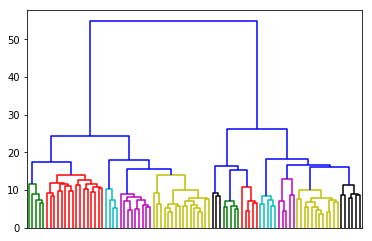

In [504]:
m_refgst = mergeDfs(ref_gst)
somhcl_xdf_nonorth = comboCluster(m_refgst, nonort_gene_list, cth=15)

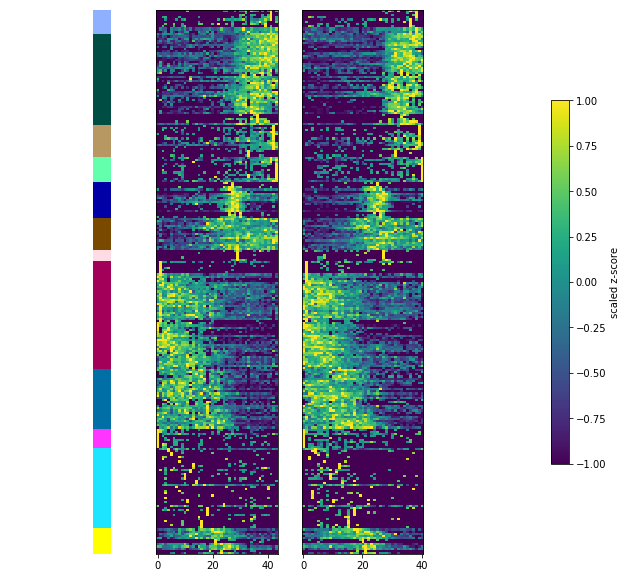

In [505]:
plt.figure(figsize=(10,10))

somhcl = somhcl_xdf_nonorth

gene_order = somhcl.sort_values(by=['hcl','som']).index
Npl = len(ref_gst)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl['hcl']):
    y = 1.0*len(somhcl[somhcl['hcl'] == i])/len(somhcl)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(ref_gst):
    plt.subplot(1,Npl,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate_h else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(outname + 'nonorth.pdf', bbox_inches = 'tight')
somhcl.to_csv(outname + 'nonorth.tsv', sep = '\t')

plt.show()

# correlations

In [ ]:
def geneCorrelation(df1, df2):
    df1 = df1.groupby(df1.index).aggregate(np.mean)
    df2 = df2.groupby(df2.index).aggregate(np.mean)
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [ ]:
def simulationCorrelations(n1, n2, N = 1000, ths = [0.05,0.01,0.005,0.001], seed = 123456):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    np.random.seed(seed)
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    hist = np.histogram(ps, bins = 100, normed=True)
    hdf = pd.DataFrame({'prob': hist[0], 'corr': [hist[1][i:i+2].mean() for i in range(len(hist[0]))]})
    dx = hdf.loc[1,'corr']-hdf.loc[0,'corr']
    hdf['cum'] = hdf['prob'].cumsum()*dx
    canti = {th: hdf.loc[hdf[hdf['cum']<=th].index[-1], 'corr'] for th in ths}
    ccorr = {th: hdf.loc[hdf[hdf['cum']>=1-th].index[0], 'corr'] for th in ths}
    return ps, canti, ccorr

In [ ]:
corr_mouse_chi_df = geneCorrelation(mousedf, humandf_wmg)
corr_chi_mouse_df = geneCorrelation(humandf, mousedf_whg)

In [ ]:
ps, ca, cc = simulationCorrelations(len(mousedf.columns), len(humandf.columns), N = 5000, seed = 112513)

In [ ]:
ca, cc

# Unbiased comparison

In [ ]:
def hierarchicalClustering(df, cth = 100, plot = False):
    Z = linkage(df, method='ward')
    dg = dendrogram(Z, no_labels=True, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

In [ ]:
def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

In [ ]:
mdf_whg = mousedf_whg.merge(humandf, how = 'inner', left_index = True, right_index = True)
mdf_wmg = mousedf.merge(humandf_wmg, how = 'inner', left_index = True, right_index = True)

In [ ]:
mdf_whg['gene'] = mdf_whg.index
mdf_whg = mdf_whg.groupby('gene').aggregate(np.mean)

In [ ]:
mdf_wmg['gene'] = mdf_wmg.index
mdf_wmg = mdf_wmg.groupby('gene').aggregate(np.mean)

In [ ]:
genesMouse_wmg = pd.Series([idx for idx in genesMouse if idx in list(mdf_wmg.index)])
genesHuman_whg = pd.Series([idx for idx in genesHuman if idx in list(mdf_whg.index)])

In [ ]:
plt.figure(figsize=(5,7))
plt.subplot(151)
plt.imshow(scalezscore(mdf_wmg.loc[genesMouse_wmg, mousedf.columns]), aspect = 'auto')
plt.subplot(152)
plt.imshow(scalezscore(mdf_wmg.loc[genesMouse_wmg, humandf.columns]), aspect = 'auto')

plt.subplot(154)
plt.imshow(scalezscore(mdf_whg.loc[genesHuman_whg, mousedf.columns]), aspect = 'auto')
plt.subplot(155)
plt.imshow(scalezscore(mdf_whg.loc[genesHuman_whg, humandf.columns]), aspect = 'auto')
plt.show()

In [ ]:
Z_wmg, dg_wmg = hierarchicalClustering(mdf_wmg.loc[genesMouse_wmg], cth = 18, plot=True )
plt.show()
Z_whg, dg_whg = hierarchicalClustering(mdf_whg.loc[genesHuman_whg], cth = 15, plot = True)
plt.show()

In [ ]:
annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3A','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

In [ ]:
ghcl_wmg = getClusterByColor(dg_wmg, list(genesMouse_wmg))
ghcl_wmg = pd.Series({g: hcl for hcl in ghcl_wmg.keys() for g in ghcl_wmg[hcl]})
ghcl_whg = getClusterByColor(dg_whg, genesHuman_whg)
ghcl_whg = pd.Series({g: hcl for hcl in ghcl_whg.keys() for g in ghcl_whg[hcl]})

In [ ]:
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figComparisonMouseHuman/'

In [ ]:
ghcl_wmg.to_csv(path + 'genes_mouseversion_hcl.txt', sep = '\t')
ghcl_whg.to_csv(path + 'genes_humanversion_hcl.txt', sep = '\t')

In [ ]:
plt.figure(figsize=(9,10))

genes = ghcl_wmg.sort_values().index[::-1]

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4 # 3
pv = 0.01
for i in set(ghcl_wmg):
    y = 1.0*len(ghcl_wmg[ghcl_wmg==i])/len(ghcl_wmg)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])    
    corrs = corr_mouse_chi_df.loc[ghcl_wmg[ghcl_wmg==i].index]
    if sum(corrs>=cc[pv]) >= int(cc[pv]*len(corrs)/2):
        plt.scatter([xb+0.3], [y0+0.5*y], marker = '*', c= 'k')
    if sum(corrs<= ca[pv]) >= -int(ca[pv]*len(corrs)/2):
        plt.scatter([xb-0.3], [y0+0.5*y], marker = '*', c= 'k')     
    y0 += y     
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

plt.subplot(142)
plt.imshow(scalezscore(mdf_wmg.loc[genes, mousedf.columns]), aspect = 'auto')
plt.title('mouse'); 
plt.subplot(143)
plt.imshow(scalezscore(mdf_wmg.loc[genes, humandf.columns]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), [ortos[ortos['Mouse gene stable ID']==g]['Mouse gene name'].values[0] if ortos[ortos['Mouse gene stable ID']==g]['Gene name'].values[0] in annotate else '' for g in genes])

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'comparison_mouseversion.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(9,10))

genes = ghcl_whg.sort_values().index[::-1]

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4; 
pv = 0.01
for i in set(ghcl_whg):
    y = 1.0*len(ghcl_whg[ghcl_whg==i])/len(ghcl_whg)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])    
    corrs = corr_chi_mouse_df.loc[ghcl_whg[ghcl_whg==i].index]
    if sum(corrs>=cc[pv]) >= int(cc[pv]*len(corrs)/2):
        plt.scatter([xb+0.3], [y0+0.5*y], marker = '*', c= 'k')
    if sum(corrs<= ca[pv]) >= -int(ca[pv]*len(corrs)/2):
        plt.scatter([xb-0.3], [y0+0.5*y], marker = '*', c= 'k')     
    y0 += y     
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

plt.subplot(142)
plt.imshow(scalezscore(mdf_whg.loc[genes, mousedf.columns]), aspect = 'auto')
plt.title('mouse'); 
plt.subplot(143)
plt.imshow(scalezscore(mdf_whg.loc[genes, humandf.columns]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), [ortos[ortos['Gene stable ID']==g]['Gene name'].values[0] if ortos[ortos['Gene stable ID']==g]['Gene name'].values[0] in annotate else '' for g in genes])

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'comparison_humanversion.pdf', bbox_inches = 'tight')
plt.show()

1. Wonder if there are subtle differences in relative positioning and domain representation of some genes e.g looking at Cdx2, CyP26A, Tbx6…are they exactly in the same domain? Are node genes conserved and what is their relative positioning with regard to T or Cdx2? How conserved are the presomitic/somitic domains (Meox/Tbx6)

2. Are there conserved modules? Non conserved modules? e.g we don’t see much neural in the human, is this reflected in the comparison?

3. Is there a metabolic signature somewhere?

I have mostly the same questions as Alfonso really – mostly, is there a way to statistically tell if a cluster (and also specific genes within equivalent clusters) are differentially expressed between the two systems? I’d expect there to be differences in:
The identity of the genes which are detectably (or significantly) expressed
The level of gene expression for different genes
The position of gene expression patterns (it would be particularly interesting if there were conserved ‘units’ of gene expression, which were still evident in a pattern formation but which were perhaps shifted or changed proportion of expression domains… I’m thinking particularly of the PSM/somites regulatory network here, but it should be existant for other regulatory modules too)
 
Might be good to think of ways to test things like this between datasets? (which could then come in useful for any further comparisons you decide to make once the pipeline is set up). Just an idea – of course these things are always easier to think of than to actually do…!!

In [ ]:
plt.figure(figsize=(9,5))

genes = ['CDX2','CYP26A1','TBX6','TBXT','MEOX1','NODAL', 'MT1X'] # gms_hcls.index[::-1]
gm = [ortos[ortos['Gene name']==g]['Mouse gene stable ID'].values[0] for g in genes]
gh = [ortos[ortos['Gene name']==g]['Gene stable ID'].values[0] for g in genes]

plt.subplot(142)
plt.imshow(scalezscore(mouse.loc[gm]), aspect = 'auto')
plt.title('mouse'); plt.yticks([])
plt.subplot(143)
plt.imshow(scalezscore(chi.loc[gh]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), genes)

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig(path+'comparison_mouse_chihuman_CherryPicked.pdf', bbox_inches = 'tight')
plt.show()

1. First on the Signalling and Hox panels. I like the idea that Naomi has of including these in Fig3 of #1. The question is how to present it and whether there is something worth highlighting,

On the signalling, the ligands, the most intriguing observation for me is the presence of Wnt3 (NOT Wnt3A) at the posterior tip. If my reading of the developmental stage of these Gstds is correct, in the equivalent stage of the mouse, Wnt3 is not expressed, so this is interesting. I am also curious about Wnt4. In both cases, it would be good to see whether you see them in the comparison with the mouse. Thinking as I write, it might be good to have a supplementary figure in #2 comparing the organization of signalling in mouse and human. I cannot see anything else (beyond the interest of the organization) in FGF and BMP. Nodal appears in other plots, thus must be there but I don’t think that this might be too important to show here. About Shh, again, I have seen it in some of the plots and the response, the marker for Shh signalling, is Ptch.

In terms of trying to see where signalling is happening (readouts), I would look for the following. For Wnt signalling, it would be good to look at Axin2, Rnf43, Lef1 and Dkk1. These could appear, below all the Wnts, For BMP, there are no clear readouts but for FGF there are: Sprouty genes and also Dusp. The expression of all these genes should deliver the signalling landscapes.

The Hox are, as always, interesting. It would be good to see them arrange ‘in order” i.e. starting from cluster A and then 1,2,3…..; cluster B, 1,2.3….but I would suggest that in the figure that Naomi has in mind, rather than these spatial plots I would suggest to have an average expression for each and just have a 4x13 diagram. The point simply to show that, om average, all are on until 11 and that 11,12,13 are off. This tells us something about time and space.

Let me know if this is not clear.\

2. On the comparison based on cherry picked genes. Good in general. There are details. The two that I highlight here are that many of the P genes, tend to be closer to the P end in the human than in the mouse. Also, Meox highlights something, namely that there is Meox -ve area anterior in the Anterior which is not in the mouse, I have noticed this with a number of genes in the heatmaps. This could be genuine differences or stage differences, but is worth noting.

I think that this is it for now. I know Naomi is working on some mock Figs 3 and 4 for #1 using all the data that you have sent. Anna. The idea continues to be the same we have put forward earlier.

I hope I am not forgetting anything. If I do, remind me, and ask anything that might not be clear or that you wonder about


In [ ]:
def hierarchicalClustering(df):
    Z = linkage(df, method='ward')
    dg = dendrogram(Z, no_labels=True, color_threshold=100, no_plot = True)
    plt.show()
    return Z, dg

In [ ]:
#genes = [g for g in ortos['Gene name'] if 'WNT' in g]
#Z, dg = hierarchicalClustering(mznfdfcsbs.loc[FGFgenes])
#gene_order = FGFgenes[dg['leaves']]

In [ ]:
plt.figure(figsize=(9,5))


genes = [g for g in ortos['Gene name'] if 'WNT' in g]
gm = [ortos[ortos['Gene name']==g]['Mouse gene stable ID'].values[0] for g in genes]
gh = [ortos[ortos['Gene name']==g]['Gene stable ID'].values[0] for g in genes]

plt.subplot(142)
plt.imshow(scalezscore(mouse.loc[gm]), aspect = 'auto')
plt.title('mouse'); plt.yticks([])
plt.subplot(143)
plt.imshow(scalezscore(chi.loc[gh]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), genes)

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
plt.savefig(path+'comparison_mouse_chihuman_Wnt.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(9,5))

genes = [g for g in ortos['Gene name'] if 'BMP' in g]
gm = [ortos[ortos['Gene name']==g]['Mouse gene stable ID'].values[0] for g in genes]
gh = [ortos[ortos['Gene name']==g]['Gene stable ID'].values[0] for g in genes]

plt.subplot(142)
plt.imshow(scalezscore(mouse.loc[gm]), aspect = 'auto')
plt.title('mouse'); plt.yticks([])
plt.subplot(143)
plt.imshow(scalezscore(chi.loc[gh]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), genes)

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
#plt.savefig(path+'comparison_mouse_chihuman_Wnt.pdf', bbox_inches = 'tight')
plt.show()